In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
individual_household_electric_power_consumption = fetch_ucirepo(id=235) 
  
# data (as pandas dataframes) 
X = individual_household_electric_power_consumption.data.features 
y = individual_household_electric_power_consumption.data.targets 
  
# metadata 
print(individual_household_electric_power_consumption.metadata) 
  
# variable information 
print(individual_household_electric_power_consumption.variables) 


In [9]:
from torch.utils.data import random_split
# Use the class 
import importlib
import dataset
importlib.reload(dataset)
# Assuming `X` is your input DataFrame and `lam` is the parameter for the dataset
data = dataset.ElectricityDataset(X, lam=20)

# Calculate the lengths for train and test splits
train_size = int(0.8 * len(data))  # 80% for training
test_size = len(data) - train_size  # 20% for testing

# Perform the split
C, test_dataset = random_split(data, [train_size, test_size])

/data/ascaffid/ROMA/RoMA-Experiments/Interpolation_Electricity/Interpolation_Electricity/dataset.py:158: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  day_index = pd.date_range(start=pd.to_datetime(day), periods=1440, freq='T')
/data/ascaffid/ROMA/RoMA-Experiments/Interpolation_Electricity/Interpolation_Electricity/dataset.py:160: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group = group.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')
/data/ascaffid/ROMA/RoMA-Experiments/Interpolation_Electricity/Interpolation_Electricity/dataset.py:158: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  day_index = pd.date_range(start=pd.to_datetime(day), periods=1440, freq='T')
/data/ascaffid/ROMA/RoMA-Experiments/Interpolation_Electricity/Interpolation_Electricity/dataset.py:16

In [10]:
import numpy as np
np.save("dataset.npy", data)

Does the data object contain NaNs? False


/tmp/ipykernel_1519668/459599785.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  has_nans = np.any([np.isnan(sample['values']).any() for sample in data])


In [1]:
%cd /data/ascaffid/ROMA/RoMA-Experiments/Interpolation_Electricity
!pwd
import os
from roma.model import (RoMAForPreTraining,RoMAForPreTrainingConfig, EncoderConfig)
from roma.trainer import Trainer, TrainerConfig
from roma.utils import get_encoder_size
import torch.nn as nn
# from Interpolation_Electricity.dataset import CustomCollate,ElectricityDataset
from torch.utils.data import random_split
import sys
import numpy as np
sys.path.append(os.path.abspath("/data/ascaffid/ROMA/RoMA-Experiments/Interpolation_Electricity/Interpolation_Electricity"))
import dataset
import importlib
importlib.reload(dataset)

data = np.load("dataset.npy",allow_pickle=True)
# Check for NaNs in the dataset
has_nans = np.any([np.isnan(sample['values']).any() for sample in data])
print(f"Does the data object contain NaNs? {has_nans}")
def pretrain():
    # Let's use the tiny model:
    encoder_args = get_encoder_size("RoMA-small")

    model_config = RoMAForPreTrainingConfig(
        encoder_config=EncoderConfig(**encoder_args),
        decoder_config=EncoderConfig(**encoder_args),

        tubelet_size=(1, 1, 1),
        n_channels=1,
        n_pos_dims=2
    )

    # Have beelow in the ENV (not everything)
    model          = RoMAForPreTraining(model_config)
    model.set_loss_fn(nn.MSELoss())
    trainer_config = TrainerConfig(project_name="Interpolation_Electricity",optimizer="adamw")
    trainer        = Trainer(trainer_config)
    train_size                  = int(0.8 * len(data))  # 80% for training
    test_size                   = len(data) - train_size  # 20% for testing
    train_dataset, test_dataset = random_split(data, [train_size, test_size])
    colate_fn                   = dataset.CustomCollate()
    trainer.train(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        model=model,
        train_collate_fn=colate_fn,
        eval_collate_fn=colate_fn,
    )

# if __name__ == '__main__':
    
#     pretrain()


/data/ascaffid/ROMA/RoMA-Experiments/Interpolation_Electricity
/data/ascaffid/ROMA/RoMA-Experiments/Interpolation_Electricity
Does the data object contain NaNs? False


/tmp/ipykernel_1588819/656488677.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  has_nans = np.any([np.isnan(sample['values']).any() for sample in data])


In [2]:
batch = data[:16]
collate_fn = dataset.CustomCollate()
batch = collate_fn(batch)

In [8]:
batch['positions'][0]

tensor([[0.0222, 0.0250, 0.0584,  ..., 0.0000, 0.0000, 0.0000],
        [2.0000, 4.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000]])

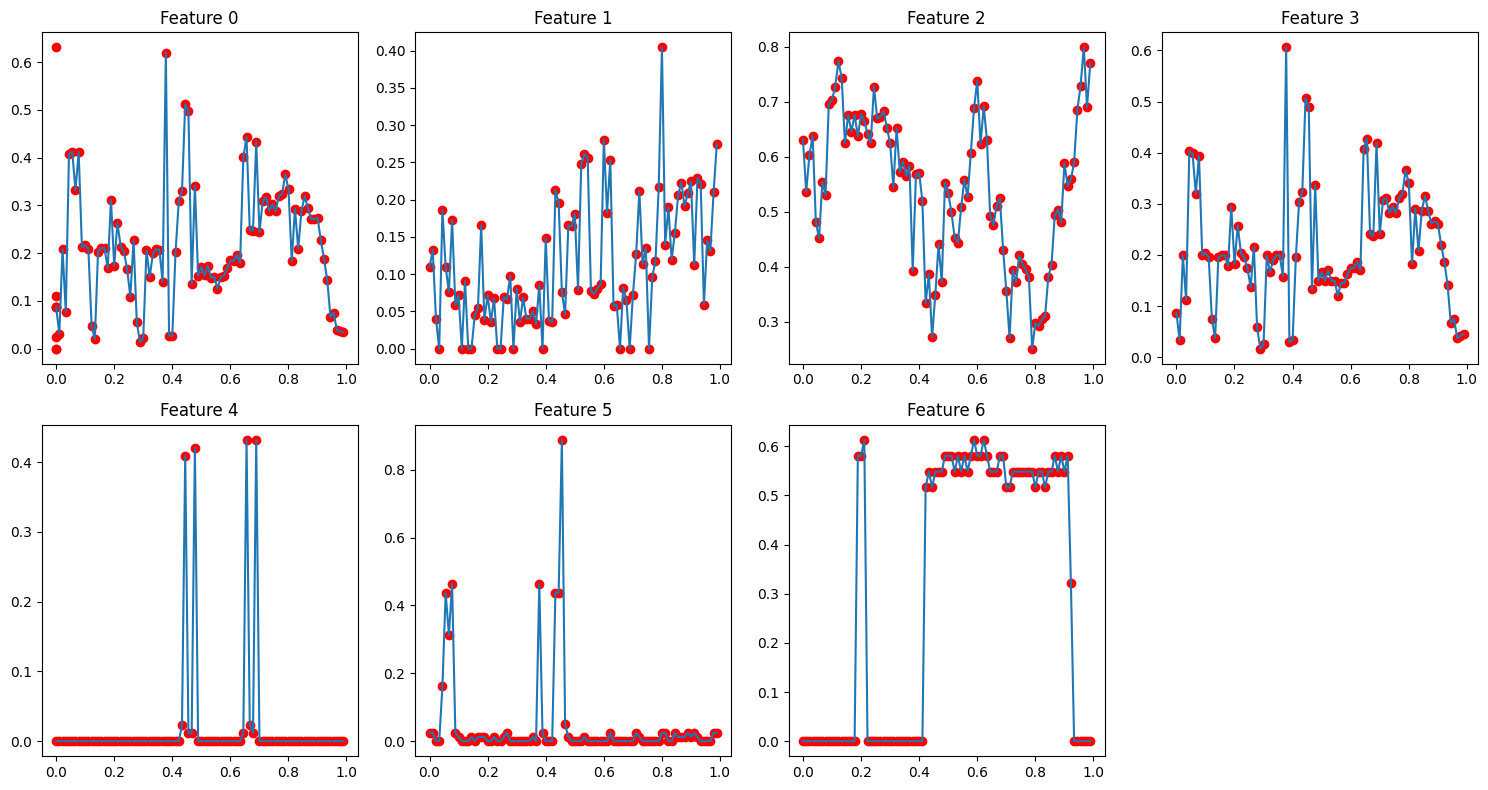

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # Create a grid of 2 rows and 4 columns
axes = axes.flatten()  # Flatten the axes array for easy indexing
sample = 1

for feature in range(7):
    mask_og = data[sample]["mask"]
    axes[feature].plot(data[sample]['times'].flatten(), data[sample]['ground_truth'][:, feature])
    values    = data[sample]['values'][mask_og]
    positions = data[sample]['positions'][:,mask_og]

    mask = np.where(positions==feature)[1]
    
    dots     = values[mask].squeeze()
    dots_pos = positions[0][mask].squeeze()
    axes[feature].scatter(dots_pos,dots, color='red')
    axes[feature].set_title(f"Feature {feature}")

# Hide the last subplot if there are fewer than 8 plo ts
axes[-1].axis('off')

plt.tight_layout()
plt.show()